# BackPropによるQAOA最適化

scikit-qulacsを用いてbackpropによる勾配計算が可能なQAOA回路を作成する。

## import

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time

from qulacs import QuantumState
from skqulacs.circuit import LearningCircuit
import qulacsvis as qvis

import made as MADE
import mcmc_function as mcmc
import ising_model as ising
from ising_model import Ising_model
import QAOA_function as qaoa
from QAOA_function import QAOA_ansatz

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['mathtext.fontset'] = 'cm'

seed = 729
rng = np.random.default_rng(seed)

## QAOA回路の定義

In [2]:
class QAOA_ansatz_backprop:	
	def __init__(self, prob_hamiltonian, mixer_hamiltonian, n_layers):
		self.n_qubits = prob_hamiltonian.get_qubit_count()
		self.prob_hamiltonian = prob_hamiltonian
		self.mixer_hamiltonian = mixer_hamiltonian
		self.n_layers = n_layers
        
		circuit = LearningCircuit(self.n_qubits)
		para = [0. for i in range(2*self.n_layers)]
        
        # get pauli data
		prob_index_list = []
		prob_pauli_id_list = []
		prob_coef = []
		for i in range(prob_hamiltonian.get_term_count()):
			pauli = prob_hamiltonian.get_term(i)
			prob_index_list.append(pauli.get_index_list())
			prob_pauli_id_list.append(pauli.get_pauli_id_list())
			prob_coef.append(pauli.get_coef().real)
        
		mix_index_list = []
		mix_pauli_id_list = []
		mix_coef = []
		for i in range(mixer_hamiltonian.get_term_count()):
			pauli = mixer_hamiltonian.get_term(i)
			mix_index_list.append(pauli.get_index_list())
			mix_pauli_id_list.append(pauli.get_pauli_id_list())
			mix_coef.append(pauli.get_coef().real)
        
		# generate a parametric quantum circuit
		n_prob_terms = self.prob_hamiltonian.get_term_count()
		n_mix_terms = self.mixer_hamiltonian.get_term_count()

		# init state preparation
		for i in range(self.n_qubits):
			circuit.add_H_gate(i)

		for i in range(self.n_layers):
			# problem hamiotinian
			for j in range(n_prob_terms):
				n_body = len(prob_pauli_id_list[j])

				# 2-bodys term
				if n_body == 2:
					if j == 0:
						circuit.add_CNOT_gate(prob_index_list[j][0], prob_index_list[j][1])
						gamma = circuit.add_parametric_RZ_gate(prob_index_list[j][1], prob_coef[j]*para[2*i])
						circuit.add_CNOT_gate(prob_index_list[j][0], prob_index_list[j][1])
					else:
						circuit.add_CNOT_gate(prob_index_list[j][0], prob_index_list[j][1])
						circuit.add_parametric_RZ_gate(prob_index_list[j][1], prob_coef[j]*para[2*i], share_with=gamma)
						circuit.add_CNOT_gate(prob_index_list[j][0], prob_index_list[j][1])
				# 1-body term
				if n_body == 1:
					if j == 0:
						gamma = circuit.add_parametric_RZ_gate(prob_index_list[j][0], prob_coef[j]*para[2*i])   
					else:
						circuit.add_parametric_RZ_gate(prob_index_list[j][0], prob_coef[j]*para[2*i], share_with=gamma)

			# mixer hamiltonian
			for j in range(n_mix_terms):
				if j == 0:
					beta = circuit.add_parametric_RX_gate(prob_index_list[j][0], prob_coef[j]*para[2*i+1])
				else:
					circuit.add_parametric_RX_gate(prob_index_list[j][0], prob_coef[j]*para[2*i+1], share_with=beta)
            
		self.circuit = circuit
		self.para = para
    
	def get_parameter(self):
		return self.para

	def get_qulacs_circuit(self):
		return self.circuit.get_circuit_info()

	def get_skqulacs_circuit(self):
		return self.circuit

	def get_parameter_count(self):
		return len(self.para)

	def get_qubit_count(self):
		return self.n_qubits

	def get_grad(self, prob_hamiltonian):
		init_state = [0.0 for i in range(len(self.para))]
		return self.circuit.backprop(init_state, prob_hamiltonian)

	def set_parameter(self, para):
		self.circuit.update_parameters(para)
		self.para = para
    
	def run_circuit(self):
		return self.circuit.run()

### 回路チェック

In [13]:
n_qubits = 15
instance = Ising_model(n_qubits, seed, type='SK')
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_qubits)

n_layers = 5
backprop_circuit = QAOA_ansatz_backprop(prob_hamiltonian, mixer_hamiltonian, n_layers)

print(backprop_circuit.get_qulacs_circuit())
#qvis.circuit_drawer(backprop_circuit.get_qulacs_circuit(), output_method='mpl')

*** Quantum Circuit Info ***
# of qubit: 15
# of step : 272
# of gate : 1740
# of 1 qubit gate: 690
# of 2 qubit gate: 1050
Clifford  : no
Gaussian  : no

*** Parameter Info ***
# of parameter: 675



## 最適化テスト

In [14]:
def cost_QAOA_backprop(prob_hamiltonian, ansatz, para):
    n_qubits = ansatz.get_qubit_count()
    
    # apply QAOA ansatz
    ansatz.set_parameter(para)
    state = ansatz.run_circuit()
    cost_val = prob_hamiltonian.get_expectation_value(state)
    
    return cost_val

def cost(para):
	return cost_QAOA_backprop(prob_hamiltonian, backprop_circuit, para)

init_para = [rng.uniform(0, 2*np.pi) for i in range(backprop_circuit.get_parameter_count())]

### 通常の数値微分

         Current function value: -1.125742
         Iterations: 40
         Function evaluations: 990
         Gradient evaluations: 89
time 39.64644908905029 sec


/opt/anaconda3/envs/quantum/lib/python3.11/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


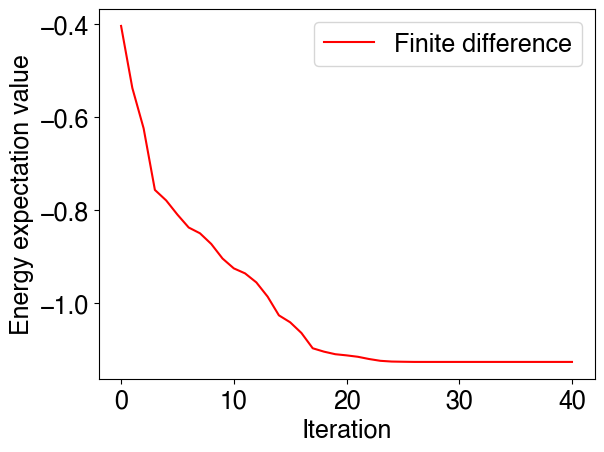

In [15]:
cost_history = []
cost_history.append(cost(init_para))
method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-6}

st_time = time.time()
opt = scipy.optimize.minimize(cost, init_para,
                              method=method,
                              callback=lambda x: cost_history.append(cost(x)),
                              options=options)
print("time",time.time()-st_time,"sec")

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="Finite difference")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()

### backprop

         Current function value: -1.125742
         Iterations: 40
         Function evaluations: 990
         Gradient evaluations: 89
time 40.068926095962524 sec


/opt/anaconda3/envs/quantum/lib/python3.11/site-packages/scipy/optimize/_minimize.py:708: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


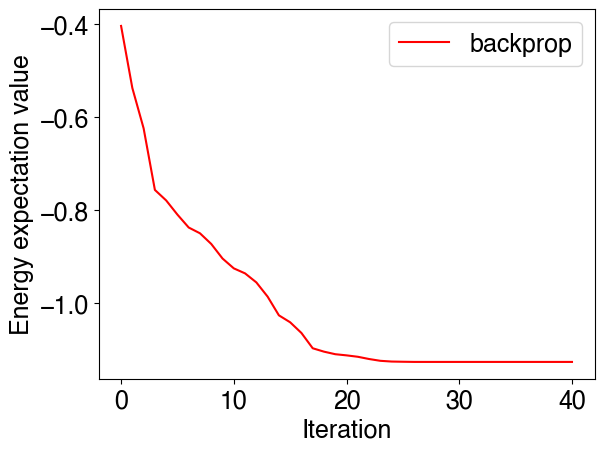

In [16]:
cost_history = []
cost_history.append(cost(init_para))
method = "BFGS"
options = {"disp": True, "maxiter": 200, "gtol": 1e-6}

st_time = time.time()
opt = scipy.optimize.minimize(cost, init_para,
                              jac=backprop_circuit.get_grad(prob_hamiltonian),
                              method=method,
                              callback=lambda x: cost_history.append(cost(x)),
                              options=options)
print("time",time.time()-st_time,"sec")

plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="backprop")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend()

## 勾配計算テスト

### 有限差分用コード

In [24]:
def get_gradient(cost, para):
    n_para = len(para)
    epsilon = 1e-6

    gradient = np.array([0.0 for i in range(n_para)])
    cost_val = cost(para) 

    #MPI並列化したいループ
    for j in range(n_para):
        tmp = para[j]  
        para[j] = tmp + epsilon  
        plus_epsilon = cost(para)

        gradient[j] = (plus_epsilon - cost_val) / epsilon
        para[j] = tmp
    
    return gradient

### テスト

In [25]:
# setting
n_qubits = 10
instance = Ising_model(n_qubits, seed, type='SK')
prob_hamiltonian = instance.get_hamiltonian()
mixer_hamiltonian = qaoa.generate_X_mixer(n_qubits)

n_layers = 5
backprop_circuit_2 = QAOA_ansatz_backprop(prob_hamiltonian, mixer_hamiltonian, n_layers)

# test
def cost(para):
	return cost_QAOA_backprop(prob_hamiltonian, backprop_circuit_2, para)

para = [rng.uniform(0, 2*np.pi) for i in range(backprop_circuit.get_parameter_count())]
backprop_circuit_2.set_parameter(para)

st_time = time.time()
grad_diff = get_gradient(cost, para)
print("time",time.time()-st_time,"sec")
print("gradient(diff):",grad_diff)

st_time = time.time()
grad_bp = backprop_circuit_2.get_grad(prob_hamiltonian)
print("time",time.time()-st_time,"sec")
print("gradient(backprop):",grad_bp)

print("difference=", np.abs(grad_diff-grad_bp))

time 0.033968210220336914 sec
gradient(diff): [ 0.19913438  0.08646131  7.39804495  0.75411252 -4.8929249   1.0714011
 -4.41596503 -0.64709239 -2.2809445  -0.0663101 ]
time 0.004216909408569336 sec
gradient(backprop): [0.19913254022070412, 0.08645623855382832, 7.398104999069097, 0.7541190697327178, -4.89290293230893, 1.071414637264793, -4.415925769160861, -0.6470796136326517, -2.280935850786398, -0.06631128511998717]
difference= [1.84409481e-06 5.07588752e-06 6.00487561e-05 6.54941462e-06
 2.19699355e-05 1.35327627e-05 3.92631508e-05 1.27789257e-05
 8.64649294e-06 1.18470940e-06]
